In [74]:
# Pathway stats
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
KEGG_pathway_df = pd.read_csv("KEGG_human_pathways_compounds.csv", dtype=str, index_col=0)
Reactome_pathway_df = pd.read_csv("Reactome_pathway_set.csv", dtype=str, index_col=0)
Reactome_human_pathways = Reactome_pathway_df[Reactome_pathway_df.index.str.contains("HSA")]

def process_paths(pathway_df):
    KEGG_pathways = pathway_df.dropna(axis=0, how='all', subset=pathway_df.columns.tolist()[1:])
    pathways = KEGG_pathways.index.tolist()
    pathway_names = KEGG_pathways["Pathway_name"].tolist()
    pathway_dict = {}

    for pathway in pathways:
        # perform ORA for each pathway
        pathway_compounds = KEGG_pathways.loc[pathway, :].tolist()
        pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "nan"]
        cpds = pathway_compounds[1:]
        if len(cpds) > 2:
            pathway_dict[pathway] = cpds
    return pathway_dict

KEGG_pathway_dict = process_paths(KEGG_pathway_df)
Reactome_pathway_dict = process_paths(Reactome_human_pathways)

In [76]:
print(len(KEGG_pathway_dict))
print(len(Reactome_pathway_dict))

261
1171


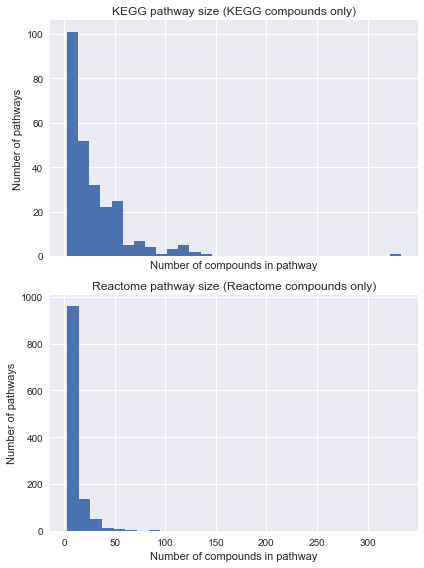

In [80]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))

pathway_length_KEGG = [len(v) for k, v in KEGG_pathway_dict.items()]
plt.style.use("seaborn")
ax1.hist(pathway_length_KEGG, bins=30)
ax1.set_title("KEGG pathway size (KEGG compounds only)")
ax1.set_ylabel("Number of pathways")
ax1.set_xlabel("Number of compounds in pathway")

pathway_length_Reactome = [len(v) for k, v in Reactome_pathway_dict.items()]
ax2.hist(pathway_length_Reactome, bins=8)
ax2.set_title("Reactome pathway size (Reactome compounds only)")
ax2.set_ylabel("Number of pathways")
ax2.set_xlabel("Number of compounds in pathway")
plt.savefig("../Figures/pathway_size_comparison.png", dpi=300)
plt.tight_layout()

# TODO remove single compound pathways